# 空间关系权重

In [1]:
#导入PySAL的子模块libpysal
import libpysal 
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd

## 数据读取与整理

In [2]:
#读取共享单车停车数据
data_stop = pd.read_csv(r'data/bicycle_points.csv')
data_stop.head(5)

,lon,lat
0,121.472519,31.273511
1,121.479947,31.258949
2,121.485236,31.266860
3,121.488845,31.290549
4,121.489748,31.290124


In [4]:
#数据进行栅格化集计
#定义范围，获取栅格化参数
lat1sh = 30.9666667;
lat2sh = 31.4833333;
lon1sh = 121.166667;
lon2sh = 121.9;
bounds = [lon1sh,lat1sh,lon2sh,lat2sh]
params = tbd.area_to_params(bounds,accuracy = 500)
#将GPS栅格化
data_stop['LONCOL'],data_stop['LATCOL'] = tbd.GPS_to_grid(data_stop['lon'],data_stop['lat'],params)
#统计每个栅格有多少数据量
data_count = data_stop.groupby(['LONCOL','LATCOL'])['lon'].count().rename('count').reset_index()
#生成栅格地理图形
data_count['geometry'] = tbd.grid_to_polygon([data_count['LONCOL'],data_count['LATCOL']],params)
#转为GeoDataFrame
data_count = gpd.GeoDataFrame(data_count)
data_count.head(5)

,LONCOL,LATCOL,count,geometry
0,58,68,1,"POLYGON ((121.46902 31.27019, 121.47428 31.270..."
1,59,69,1,"POLYGON ((121.47428 31.27468, 121.47954 31.274..."
2,59,71,2,"POLYGON ((121.47428 31.28368, 121.47954 31.283..."
3,59,72,1,"POLYGON ((121.47428 31.28817, 121.47954 31.288..."
4,59,74,1,"POLYGON ((121.47428 31.29717, 121.47954 31.297..."


<AxesSubplot:>

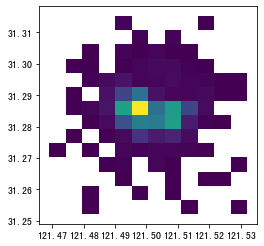

In [4]:
data_count.plot(column = 'count')

In [5]:
#转换投影坐标系以便以距离计算空间权重
data_count.crs = {'init':'epsg:4326'}
data_count_2416 = data_count.to_crs(epsg = '2416')

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## 空间关系权重获取

In [6]:
#固定距离范围
wq = libpysal.weights.DistanceBand.from_dataframe(data_count_2416,1000)

/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 3 islands with ids: 82, 87, 89.
  warnings.warn(message)


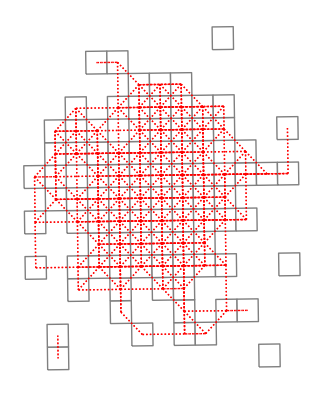

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(1,(5,5),dpi = 100)
ax = plt.subplot(111)
#绘制栅格
data_count_2416.plot(ax = ax,edgecolor='grey', facecolor='w')
#绘制邻接关系
wq.plot(data_count_2416, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
plt.axis('off')
plt.show()

In [8]:
#KNN
wq = libpysal.weights.KNN.from_dataframe(data_count_2416,k=3)
#面临接：Rook
wq = libpysal.weights.Rook.from_dataframe(data_count_2416)
#面临接：Queen
wq = libpysal.weights.Queen.from_dataframe(data_count_2416)

/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
 There are 7 islands with ids: 0, 1, 34, 82, 87, 89, 91.
  warnings.warn(message)
/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 5 islands with ids: 0, 82, 87, 89, 91.
  warnings.warn(message)


In [9]:
#整理中心点信息
points = np.array([data_count_2416.centroid.x.values,
                   data_count_2416.centroid.y.values]).T
#划分泰森多边形
region_df, point_df = libpysal.cg.voronoi.voronoi_frames(points)
#Delaunay三角测量
wq = libpysal.weights.contiguity.Voronoi(points)

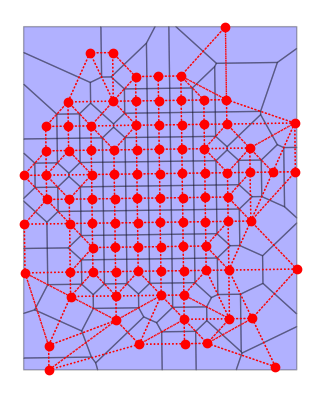

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(1,(5,5),dpi = 100)
ax = plt.subplot(111)
#绘制泰森多边形
region_df.plot(ax=ax, color='blue',edgecolor='black', alpha=0.3)
point_df.plot(ax=ax, color='red')
#绘制邻接关系
wq.plot(data_count_2416, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
plt.axis('off')
plt.show()